<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
# import plotly.express as px
%matplotlib inline

from sklearn.metrics import cohen_kappa_score, roc_curve, f1_score, make_scorer

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

# print(len(df[df['gender'] == 'other']))
## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Imputing

In [4]:
m_df = df[df['gender'] == 'male']
f_df = df[df['gender'] == 'female']

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 'male':
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

In [5]:
residence_type_map = {
    'urban':0,
    'rural':1
}
df['residence_type'] = df['residence_type'].map(residence_type_map)
# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})
# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

<h4>Binning

In [6]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

In [7]:
def add_dummy(target_df, origin_df, col):
    abbrev = col[:2] + '_'
    for cat in origin_df[col].value_counts().index.tolist()[1:]:
        target_df[abbrev + str(cat)] = origin_df[col] == cat
        target_df[abbrev + str(cat)] = target_df[abbrev + str(cat)].map({False: 0, True: 1})


In [8]:
df_dummies = pd.DataFrame(index=df.index)

add_dummy(df_dummies, df, 'work_type')
add_dummy(df_dummies, df, 'smoking_status')
add_dummy(df_dummies, df, 'age_bin')
add_dummy(df_dummies, df, 'avg_glucose_level_bin')
add_dummy(df_dummies, df, 'bmi_bin')

In [9]:
to_add = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'stroke']
df_dummies[to_add] = df[to_add]

## Dummy dataset creation
SVM reequires categorical attributes to be number encoded if they're ordinal, or dummy encoded if they aren't. That means smoking_statusa and work_type must be dummy encoded. In order to keep things simple, i dummy encoded all the features.

In [10]:
df_dummies.head()

,wo_self-employed,wo_children,wo_govt-job,wo_never-worked,sm_unknown,sm_formerly-smoked,sm_smokes,"ag_(20.0, 30.0]","ag_(-0.1, 11.0]","ag_(30.0, 38.0]",...,"bm_(38.6, 59.7]","bm_(26.6, 28.2]","bm_(19.8, 22.6]","bm_(31.8, 34.2]",gender,hypertension,heart_disease,ever_married,residence_type,stroke
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


In [11]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, cross_validate
from IPython.display import clear_output

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop(['stroke'], axis=1), df_dummies['stroke'], test_size=0.33, random_state=42)

In [13]:
X = df_dummies.drop(['stroke'], axis=1)
y = df_dummies['stroke']
# skf = StratifiedKFold(n_splits=3)

def run_svm(X, y, w1, w2, splits, repeats, scorer):
    weights = {0:w1, 1:w2}
    model = SVC(gamma='scale', class_weight=weights)

    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=1)

    scores = cross_val_score(model, X, y, scoring=scorer, cv=cv, n_jobs=-1)
    
    return scores


## Grid search
This cell searches through different class weight combinations

In [14]:
# scoreses = []
# parameses = []
# top_score = 0
# top_params = {}

# weights = [0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10]
# splits = [3]
# repeats = 5

# kappa_scorer = make_scorer(cohen_kappa_score)
# mean_roc = 'roc_auc'

# for a in weights:
#     for b in weights:
#         for c in splits:
#             scores = run_svm(X, y, a, b, c, repeats, mean_roc)
#             perf = np.mean(scores)
#             params = {'w1': a, 'w2': b, 'splits': c, 'score': perf}
#             clear_output(wait=True)
#             if perf > top_score:
#                 top_score = perf
#                 top_params = params
#                 print(f'Score: {perf:.3f} - new best')
#             else:
#                 print(f'Score: {perf:.3f} - top score is {top_score:.3f}')
#             scoreses.append(scores)
#             parameses.append(params)

In [15]:
# top_params

In [16]:
# res = pd.DataFrame(parameses)

## All of this to show that a ratio of 20:1 is the best

In [17]:
# fig, ax = plt.subplots(figsize=(15, 10))

# for i in res['splits'].value_counts().index:
#     temp_df = res[res['splits'] == i]
#     ax.plot(temp_df['w2']/temp_df['w1'], temp_df['score'])

In [18]:
master_scores = []

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [20]:
weights = {0:0.05, 1:1.0}
model = SVC(gamma='scale', class_weight=weights)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

In [22]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)

In [23]:
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'Dummy': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [24]:
master_scores

[{'Dummy': (0.23737034660528733, 0.7390857142857143, 0.8157886033425717)}]

## Results from dummy dataset

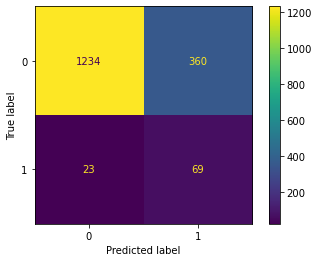

In [25]:
# plot_confusion_matrix(model, X_test, y_test)
plot_confusion_matrix(model, X_test, y_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.87      1594
           1       0.16      0.75      0.26        92

    accuracy                           0.77      1686
   macro avg       0.57      0.76      0.57      1686
weighted avg       0.94      0.77      0.83      1686



## Selecting features
Now i selected the features we had identified as the most significant: age, average glucose level, hypertension and heart disease

In [27]:
selected_columns = ['ag_(20.0, 30.0]',
       'ag_(-0.1, 11.0]', 'ag_(30.0, 38.0]', 'ag_(38.0, 45.0]',
       'ag_(51.0, 57.0]', 'ag_(65.0, 75.0]', 'ag_(11.0, 20.0]',
       'ag_(75.0, 82.0]', 'ag_(45.0, 51.0]', 'av_(80.0, 85.6]',
       'av_(65.8, 73.8]', 'av_(192.2, 271.7]', 'av_(124.1, 192.2]',
       'av_(55.0, 65.8]', 'av_(108.5, 124.1]', 'av_(91.9, 98.9]',
       'av_(85.6, 91.9]', 'av_(73.8, 80.0]', 'hypertension', 'heart_disease', 'stroke']
df_dummies_pruned = df_dummies[selected_columns]

In [28]:
X = df_dummies_pruned.drop(['stroke'], axis=1)
y = df_dummies_pruned['stroke']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

weights = {0:0.05, 1:1}
model = SVC(gamma='scale', class_weight=weights)

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [30]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'Dummy Pruned': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [31]:
# scores.mean()

## Pruned dummy dataset results
Only slightly better recall, and slightly fewer false positives

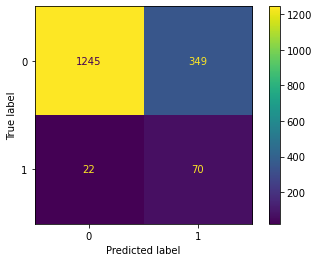

In [32]:
plot_confusion_matrix(model, X_test, y_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1594
           1       0.17      0.76      0.27        92

    accuracy                           0.78      1686
   macro avg       0.57      0.77      0.57      1686
weighted avg       0.94      0.78      0.84      1686



## Mixed type dataset
Now i made a dataset with age and avg_glucose level as continuous features, scaled using Z scores, and hypertension and heart disease as binary

In [34]:
selected_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke']
df_mixed = df[selected_columns]
df_mixed['age'] = (df_mixed['age'] - df_mixed['age'].mean()) / df_mixed['age'].std()
df_mixed['avg_glucose_level'] = (df_mixed['avg_glucose_level'] - df_mixed['avg_glucose_level'].mean()) / df_mixed['avg_glucose_level'].std()

<ipython-input-34-f29d23c549a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixed['age'] = (df_mixed['age'] - df_mixed['age'].mean()) / df_mixed['age'].std()
<ipython-input-34-f29d23c549a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixed['avg_glucose_level'] = (df_mixed['avg_glucose_level'] - df_mixed['avg_glucose_level'].mean()) / df_mixed['avg_glucose_level'].std()


In [35]:
X = df_mixed.drop(['stroke'], axis=1)
y = df_mixed['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights)

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [36]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'Mixed type': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [37]:
# scores.mean()

## Mixed dataset results
Recall was better, but false positives also increased.

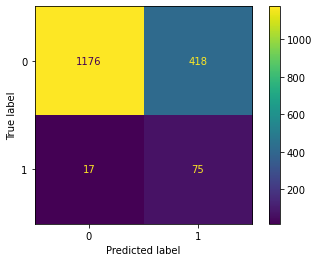

In [38]:
plot_confusion_matrix(model, X_test, y_test)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84      1594
           1       0.15      0.82      0.26        92

    accuracy                           0.74      1686
   macro avg       0.57      0.78      0.55      1686
weighted avg       0.94      0.74      0.81      1686



## Feature selection based on feature importance from Naive Bayes

In [40]:
selected = ['ag_(75.0, 82.0]',
 'ag_(65.0, 75.0]',
 'av_(192.2, 271.7]',
 'hypertension',
 'heart_disease',
 'av_(124.1, 192.2]',
 'ag_(20.0, 30.0]',
 'ag_(-0.1, 11.0]',
 'ag_(30.0, 38.0]',
 'ag_(38.0, 45.0]',
 'av_(73.8, 80.0]',
 'av_(80.0, 85.6]',
 'stroke']

In [41]:
df_sel = df_dummies[selected]

In [42]:
X = df_sel.drop(['stroke'], axis=1)
y = df_sel['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True)

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [43]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'NB Selected': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [44]:
# scores.mean()

# Naive Bayes selected dataset results

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1594
           1       0.16      0.73      0.26        92

    accuracy                           0.77      1686
   macro avg       0.57      0.75      0.56      1686
weighted avg       0.94      0.77      0.83      1686



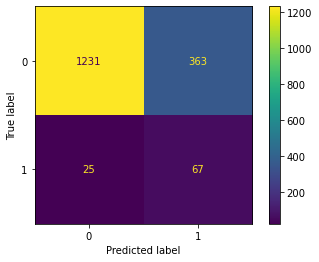

In [45]:
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test, y_pred))

## Mixed dataset with MCA feature added

In [46]:
import prince
mca_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'age_bin', 'avg_glucose_level_bin', 'bmi_bin']
df_mca = df[mca_cols]


In [47]:
mca = prince.MCA()
mca.fit(df_mca)
mca.transform(df_mca)

,0,1
0,-0.549743,-0.968528
1,-0.514676,-0.658637
2,-0.332229,-0.389982
3,-0.463017,0.087540
4,-0.378337,-0.335903
...,...,...
5105,-0.457918,-0.290580
5106,-0.488835,-0.493120
5107,-0.347460,-0.036732
5108,-0.270068,0.010023


In [48]:
df_mixed_mca = pd.merge(df_mixed, mca.row_coordinates(df_mca), left_index=True, right_index=True)

In [49]:
X = df_mixed_mca.drop(['stroke'], axis=1)
y = df_mixed_mca['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [50]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'Added MCA': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [51]:
# scores.mean()

## 

              precision    recall  f1-score   support

           0       0.98      0.71      0.83      1590
           1       0.14      0.80      0.24        96

    accuracy                           0.72      1686
   macro avg       0.56      0.76      0.53      1686
weighted avg       0.94      0.72      0.79      1686



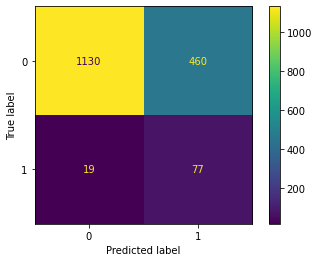

In [52]:
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test, y_pred))

In [53]:
X = df_dummies_pruned.drop(['stroke'], axis=1)
y = df_dummies_pruned['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')

model.fit(X_train, y_train)

SVC(class_weight={0: 0.05, 1: 1.0}, kernel='linear', probability=True)

In [54]:
for i, thing in enumerate(model.coef_[0]):
    print(f'{X.columns[i]}: {thing}')

ag_(20.0, 30.0]: -1.2277273782143474
ag_(-0.1, 11.0]: -1.2277515531626735
ag_(30.0, 38.0]: -1.2277173012728066
ag_(38.0, 45.0]: -1.2277753382185328
ag_(51.0, 57.0]: 0.7719383114994862
ag_(65.0, 75.0]: 0.7721618981224676
ag_(11.0, 20.0]: -1.2276193566444247
ag_(75.0, 82.0]: 0.772363362802345
ag_(45.0, 51.0]: -1.227872644911435
av_(80.0, 85.6]: -0.0002825064361600127
av_(65.8, 73.8]: -0.0002604520058948623
av_(192.2, 271.7]: -0.00021147670282495312
av_(124.1, 192.2]: -0.0002653996349142318
av_(55.0, 65.8]: -0.00044938094454316513
av_(108.5, 124.1]: -0.00023600771377019214
av_(91.9, 98.9]: -0.00028797419099646504
av_(85.6, 91.9]: -0.0004933818266827927
av_(73.8, 80.0]: -0.00032352731695528547
hypertension: 0.00022858350409471484
heart_disease: 0.00027895614825812487


In [55]:
model.coef_[0]

array([-1.22772738e+00, -1.22775155e+00, -1.22771730e+00, -1.22777534e+00,
        7.71938311e-01,  7.72161898e-01, -1.22761936e+00,  7.72363363e-01,
       -1.22787264e+00, -2.82506436e-04, -2.60452006e-04, -2.11476703e-04,
       -2.65399635e-04, -4.49380945e-04, -2.36007714e-04, -2.87974191e-04,
       -4.93381827e-04, -3.23527317e-04,  2.28583504e-04,  2.78956148e-04])

X.columns

In [56]:
X = df[['age', 'gender']]
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [57]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'Age and gender': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [58]:
# scores.mean()

              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1590
           1       0.14      0.81      0.24        96

    accuracy                           0.71      1686
   macro avg       0.56      0.76      0.53      1686
weighted avg       0.94      0.71      0.79      1686



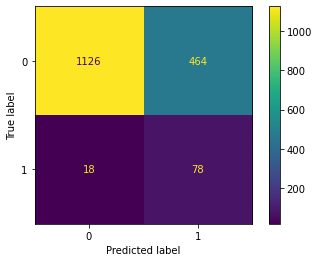

In [59]:
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test, y_pred))

In [60]:
df_full = pd.DataFrame()
to_copy1 = ['age', 'heart_disease', 'hypertension', 'bmi', 'avg_glucose_level', 'gender', 'ever_married', 'residence_type', 'stroke']
df_full[to_copy1] = df[to_copy1]
to_copy2 = ['wo_self-employed', 'wo_children', 'wo_govt-job', 'wo_never-worked', 'sm_unknown', 'sm_formerly-smoked', 'sm_smokes']
df_full[to_copy2] = df_dummies[to_copy2]

X = df_full.drop('stroke', axis=1)
y = df_full['stroke']

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X, y)

In [62]:
df_scaled = pd.DataFrame(X_scaled, columns=df_full.drop('stroke', axis=1).columns)

In [63]:
from sklearn.feature_selection import SelectKBest, chi2
X = df_scaled
y = df_full['stroke']
selector = SelectKBest(chi2, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)
X_selected = X.iloc[:,cols]

In [64]:
X_selected

,age,heart_disease,hypertension,ever_married,wo_children
0,0.817073,1.0,0.0,1.0,0.0
1,0.743902,0.0,0.0,1.0,0.0
2,0.975610,1.0,0.0,1.0,0.0
3,0.597561,0.0,0.0,1.0,0.0
4,0.963415,0.0,1.0,1.0,0.0
...,...,...,...,...,...
5104,0.975610,0.0,1.0,1.0,0.0
5105,0.987805,0.0,0.0,1.0,0.0
5106,0.426829,0.0,0.0,1.0,0.0
5107,0.621951,0.0,0.0,1.0,0.0


In [65]:
X = X_selected
y = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [66]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'Chi2 Selected': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [67]:
# scores.mean()

              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1590
           1       0.14      0.80      0.24        96

    accuracy                           0.71      1686
   macro avg       0.56      0.76      0.53      1686
weighted avg       0.94      0.71      0.79      1686



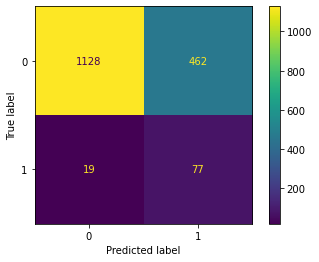

In [68]:
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test, y_pred))

In [69]:
scaler = MinMaxScaler()
df_full['mca0'] = df_mixed_mca[0]
df_full['mca1'] = df_mixed_mca[1]
df_full_scaled = pd.DataFrame(scaler.fit_transform(df_full.drop('stroke', axis=1), df_full['stroke']), columns=df_full.drop('stroke', axis=1).columns)

In [70]:
df_full_scaled

,age,heart_disease,hypertension,bmi,avg_glucose_level,gender,ever_married,residence_type,wo_self-employed,wo_children,wo_govt-job,wo_never-worked,sm_unknown,sm_formerly-smoked,sm_smokes,mca0,mca1
0,0.817073,1.0,0.0,0.512658,0.801265,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.044480,0.114797
1,0.743902,0.0,0.0,0.354430,0.679023,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055231,0.182208
2,0.975610,1.0,0.0,0.426160,0.234512,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111161,0.240649
3,0.597561,0.0,0.0,0.466245,0.536008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.071067,0.344525
4,0.963415,0.0,1.0,0.246835,0.549349,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097026,0.252413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.975610,0.0,1.0,0.341772,0.132167,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072630,0.262272
5105,0.987805,0.0,0.0,0.584388,0.323516,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063152,0.218213
5106,0.426829,0.0,0.0,0.386076,0.128658,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106492,0.317492
5107,0.621951,0.0,0.0,0.280591,0.513203,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.130217,0.327663


In [71]:
from sklearn.feature_selection import RFECV
X = df_full_scaled
y = df_full['stroke']

estimator = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=5, scoring='f1')
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

[ True  True False False  True False False False False  True False False
 False  True  True False  True]
[ 1  1  3  8  1 10  4  7  5  1  6 11  2  1  1  9  1]


In [72]:
cols = selector.get_support(indices=True)
RFE_select = X.iloc[:,cols]

In [73]:
RFE_select.head()

,age,heart_disease,avg_glucose_level,wo_children,sm_formerly-smoked,sm_smokes,mca1
0,0.817073,1.0,0.801265,0.0,1.0,0.0,0.114797
1,0.743902,0.0,0.679023,0.0,0.0,0.0,0.182208
2,0.975610,1.0,0.234512,0.0,0.0,0.0,0.240649
3,0.597561,0.0,0.536008,0.0,0.0,1.0,0.344525
4,0.963415,0.0,0.549349,0.0,0.0,0.0,0.252413


In [74]:
X = RFE_select
y = df_full['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [75]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

# scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
master_scores.append({'RFE Selected': (scores['test_f1'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean())})

In [76]:
# scores.mean()

              precision    recall  f1-score   support

           0       0.98      0.71      0.83      1590
           1       0.15      0.81      0.25        96

    accuracy                           0.72      1686
   macro avg       0.57      0.76      0.54      1686
weighted avg       0.94      0.72      0.79      1686



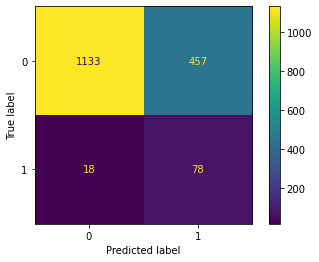

In [77]:
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test, y_pred))

In [94]:
for entry in master_scores:
    print(entry)

{'Dummy': (0.23737034660528733, 0.7390857142857143, 0.8157886033425717)}
{'Dummy Pruned': (0.22505753466093809, 0.7398448979591837, 0.8022604098429496)}
{'Mixed type': (0.21230505745480063, 0.8197387755102039, 0.828475023095658)}
{'NB Selected': (0.22508552736832385, 0.7446530612244899, 0.7860220248593266)}
{'Added MCA': (0.21913457168845052, 0.826538775510204, 0.8402735953640716)}
{'Age and gender': (0.2161055014998277, 0.8249551020408163, 0.833553590325019)}
{'Chi2 Selected': (0.2169402882756818, 0.8290204081632653, 0.8398976736373561)}
{'RFE Selected': (0.21253024595184553, 0.8341632653061224, 0.8407419585117999)}


## Garbage below
I was looking at cohen's kappa as a measure but it didn't seem very helpful. I also looked at the stroke cases we missed, they all seem much younger than the average stroke age.

In [79]:
from sklearn.metrics import cohen_kappa_score, roc_curve, f1_score

print(cohen_kappa_score(y_test, y_pred))

0.16677591125593827


In [80]:
check = pd.DataFrame(X_test)
check['probs'] = [*model.predict_proba(X_test)]
check['stroke'] = y_test

In [81]:
check[(check['stroke'] != y_pred) & (check['stroke'] == 1)]

,age,heart_disease,avg_glucose_level,wo_children,sm_formerly-smoked,sm_smokes,mca1,probs,stroke
79,0.524390,0.0,0.407672,0.0,0.0,0.0,0.276269,"[0.9811886289011577, 0.018811371098842317]",1.0
84,0.707317,0.0,0.074231,0.0,0.0,0.0,0.295491,"[0.9625150723324941, 0.0374849276675058]",1.0
106,0.609756,0.0,0.083372,0.0,1.0,0.0,0.257792,"[0.9777873530223113, 0.022212646977688613]",1.0
8,0.719512,0.0,0.097082,0.0,0.0,0.0,0.295456,"[0.9592692841121604, 0.04073071588783949]",1.0
228,0.475610,0.0,0.196842,0.0,0.0,1.0,0.290775,"[0.9869503973154631, 0.013049602684536924]",1.0
88,0.573171,0.0,0.146893,0.0,1.0,0.0,0.312794,"[0.9820014623601909, 0.01799853763980907]",1.0
12,0.658537,0.0,0.228003,0.0,0.0,1.0,0.342433,"[0.9664156381919053, 0.0335843618080946]",1.0
109,0.646341,0.0,0.041778,0.0,0.0,0.0,0.323367,"[0.974477504470078, 0.025522495529922053]",1.0
210,0.475610,0.0,0.129813,0.0,0.0,0.0,0.431437,"[0.9903697031325098, 0.009630296867490142]",1.0
238,0.621951,0.0,0.152710,0.0,0.0,0.0,0.318086,"[0.9753692676306613, 0.02463073236933872]",1.0


In [82]:
check[(check['stroke'] == y_pred) & (check['stroke'] == 1) & (check['age'] < 60)]

,age,heart_disease,avg_glucose_level,wo_children,sm_formerly-smoked,sm_smokes,mca1,probs,stroke
33,0.975610,1.0,0.912196,0.0,1.0,0.0,0.041533,"[0.5905476638352664, 0.40945233616473364]",1.0
23,1.000000,1.0,0.707137,0.0,0.0,0.0,0.162595,"[0.6193562813770352, 0.3806437186229647]",1.0
65,0.951220,0.0,0.267242,0.0,0.0,0.0,0.331676,"[0.8641366069443096, 0.1358633930556904]",1.0
179,0.987805,0.0,0.729850,0.0,0.0,0.0,0.224336,"[0.7600194529193794, 0.23998054708062047]",1.0
157,0.695122,0.0,0.769874,0.0,0.0,1.0,0.235779,"[0.9326440920520921, 0.06735590794790765]",1.0
...,...,...,...,...,...,...,...,...,...
30,0.695122,0.0,0.724587,0.0,0.0,1.0,0.214883,"[0.9333775495808216, 0.06662245041917843]",1.0
183,0.939024,0.0,0.120949,0.0,0.0,0.0,0.293110,"[0.8795328262158949, 0.12046717378410528]",1.0
44,0.731707,0.0,0.728972,0.0,0.0,1.0,0.227741,"[0.9208752501281527, 0.07912474987184742]",1.0
112,0.926829,0.0,0.236774,0.0,1.0,0.0,0.128458,"[0.8604371951273364, 0.13956280487266376]",1.0
